In [1]:
import os
import time
from tqdm import tqdm
import ast
import itertools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns


from surprise import BaselineOnly, Dataset, Reader
from surprise.model_selection import cross_validate

from cmfrec import CMF, OMF_explicit


In [2]:
#!pip install cmfrec

In [3]:
import joblib

In [4]:
from IPython.display import Markdown, display

In [5]:
cm = sns.light_palette("green", as_cmap=True)

## Import

In [6]:
# import ratings data

In [7]:
userRatings = pd.read_csv("../data/reducedUserRatings.csv", index_col=0) # issues with outliers and usernames already fixed

In [8]:
games = pd.read_excel("../data/games.xlsx")


In [9]:
# import extract informations

In [10]:
mechanics = pd.read_csv("../data/mechanics.csv")

In [11]:
themes = pd.read_csv("../data/themes.csv")

In [12]:
subcat = pd.read_csv("../data/subcategories.csv")

In [13]:
cat = games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]].copy()

In [14]:
game_info = games.iloc[:,[0] + list(range(4,30))].drop(columns=["Family","GoodPlayers"]).fillna(0)#[["ComAgeRec","LanguageEase"]]

In [15]:
rank = games[["BGGId"]+[i for i in games.columns if "Rank:" in i ]]

In [16]:
all_sideinfo = game_info.merge(mechanics,left_on = "BGGId", right_on = "BGGId", how = "left")
all_sideinfo = all_sideinfo.merge(themes,left_on = "BGGId", right_on = "BGGId", how = "left")
all_sideinfo = all_sideinfo.merge(subcat,left_on = "BGGId", right_on = "BGGId", how = "left")
all_sideinfo = all_sideinfo.merge(cat,left_on = "BGGId", right_on = "BGGId", how = "left")
all_sideinfo = all_sideinfo.merge(rank,left_on = "BGGId", right_on = "BGGId", how = "left")


In [19]:
#games_map = dict(zip(games.BGGId.unique().tolist(),pd.Series(games.BGGId.unique().tolist()).index.tolist()))

In [20]:
#user_map = dict(zip(userRatings.reducedUsername.unique().tolist(),pd.Series(userRatings.reducedUsername.unique().tolist()).index.tolist()))

## ADDITION EDA

In [21]:
def naturalNumber(val):
    """Find all non-natural number ratings"""
    return round(val) ==val

In [22]:
userRatings.groupby("reducedUsername").size().describe()

count    13060.000000
mean         5.007044
std         12.717586
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        474.000000
dtype: float64

In [23]:
userRatings.groupby("BGGId").size().describe()

count    9640.000000
mean        6.783402
std        55.875311
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max      2927.000000
dtype: float64

In [24]:
userRatings["isNatural"] = userRatings.Rating.apply(lambda x: naturalNumber(x))

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<AxesSubplot: xlabel='isNatural', ylabel='Count'>

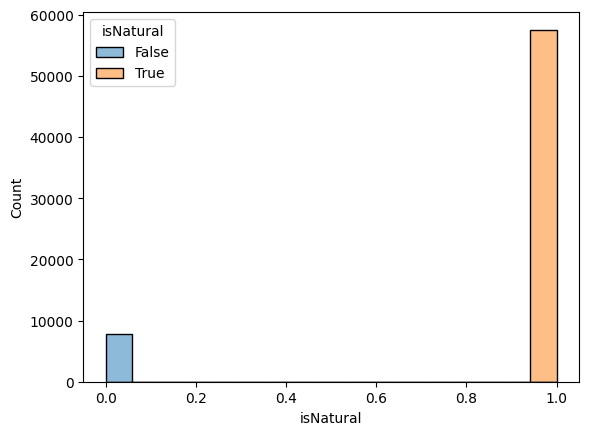

In [25]:
sns.histplot(data=userRatings,x="isNatural",hue="isNatural")

In [26]:
userRatings["Rating"] = userRatings.Rating.apply(lambda x: round(x))

In [27]:
# Number of users 
userRatings.reducedUsername.unique().shape[0]

13060

In [28]:
# Number of items
userRatings.BGGId.unique().shape[0]

9640

In [29]:
# Rating properties

In [30]:
longtail = userRatings.groupby("BGGId").size().sort_values(ascending=False).reset_index().rename(columns={0:"rating count"})#.value_counts().sort_index()


In [31]:
longtail

,BGGId,rating count
0,30549,2927
1,822,2920
2,13,2854
3,68448,1598
4,36218,1094
...,...,...
9635,136244,1
9636,288969,1
9637,246409,1
9638,198881,1


In [32]:
# plt.figure(figsize=(30, 5))
# highest_sport = userRatings['BGGId'].value_counts().index
# sns.countplot(data=userRatings, x='BGGId', order=highest_sport)
# plt.xticks(rotation=90)
# plt.title('Games by most rating')
# plt.xlabel('games')
# plt.ylabel('No. of ratings')


In [33]:
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20)  

In [34]:
pal = sns.color_palette(palette='Set1', n_colors=16)


/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


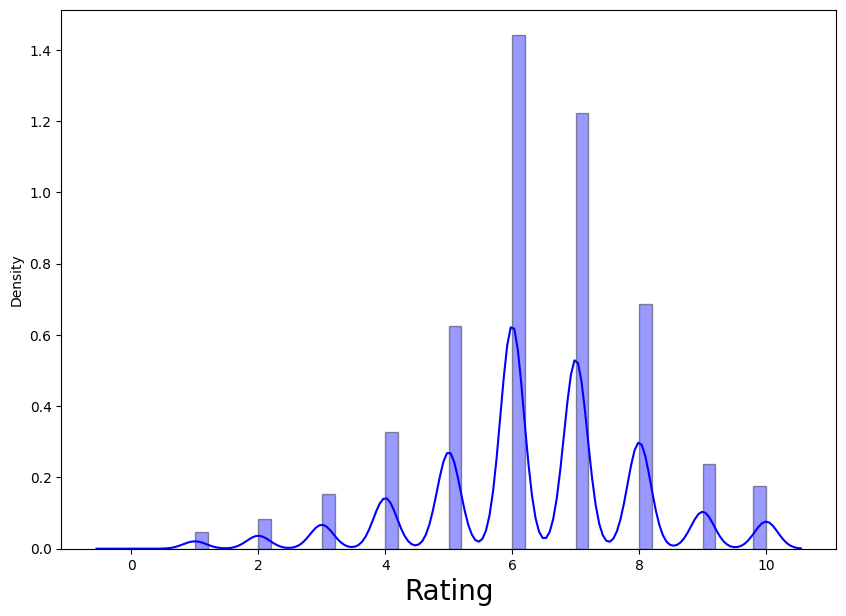

In [35]:
# Rating Distribution

distplot(1, 1, 10, 7, data=userRatings, features=['Rating'], colors=['blue'])

In [36]:
groupby_products_Ratings = userRatings.groupby('BGGId')['Rating']

ratings_products = pd.DataFrame(groupby_products_Ratings.count().clip(upper=30))
ratings_products.rename(columns={"Rating": "Rating_Count"}, inplace=True)

In [37]:
(groupby_products_Ratings.count() ==1).sum()

889

In [38]:
(groupby_products_Ratings.count() ==1).sum()/userRatings.BGGId.unique().shape[0]

0.09221991701244814

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


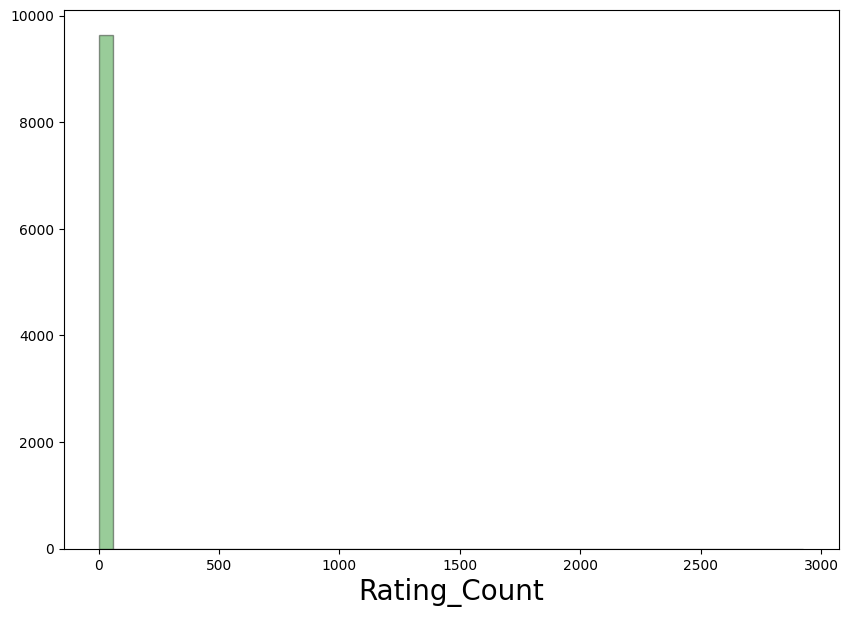

In [39]:
#Count Distribution grouped by Products
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_products_Ratings.count()).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['green'], kde=False)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


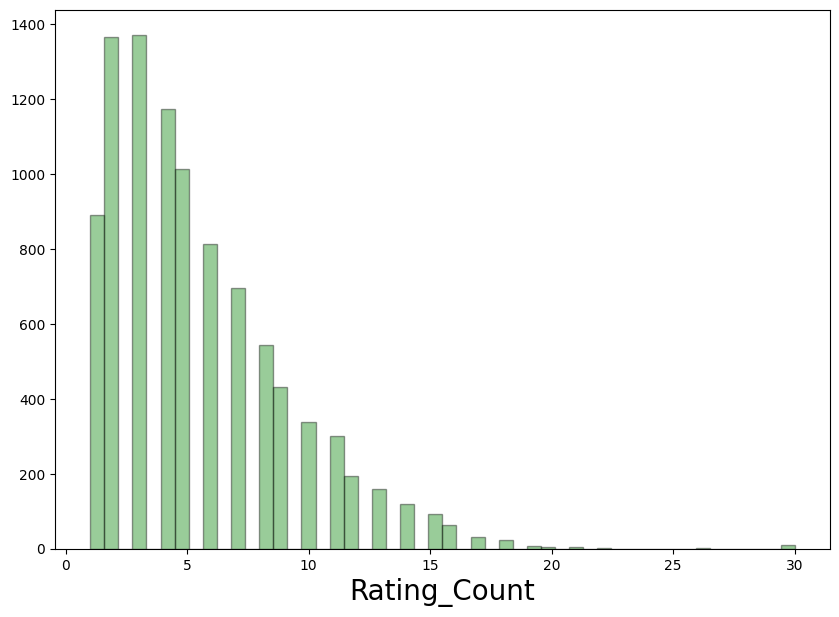

In [40]:
# Top Rating Count Distribution grouped by Products upper 30
distplot(1, 1, 10, 7, data=ratings_products, features=['Rating_Count'], colors=['green'], kde=False)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


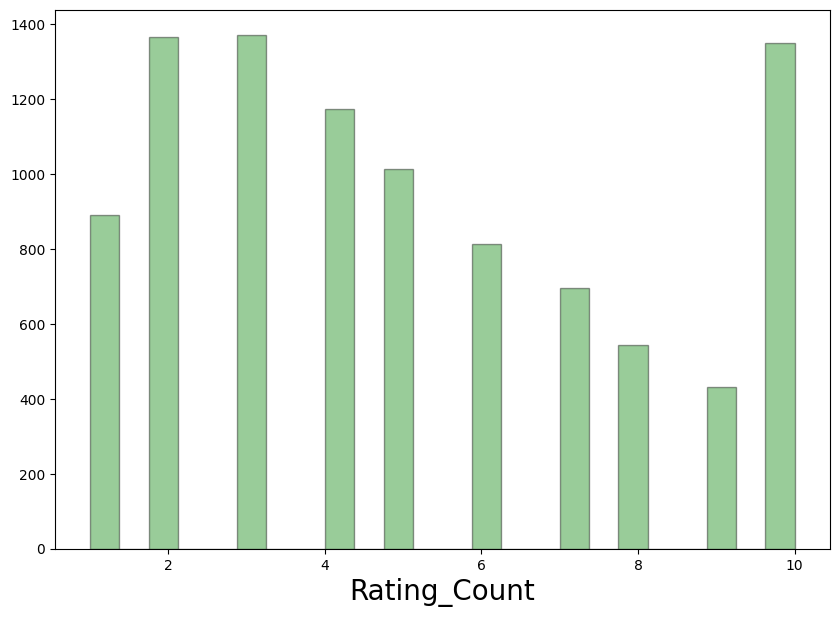

In [41]:
# Top Rating Count Distribution grouped by Products
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_products_Ratings.count().clip(upper=10)).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['green'], kde=False)

In [42]:
groupby_users_Ratings = userRatings.groupby('reducedUsername')['Rating']
rating_users = pd.DataFrame(groupby_users_Ratings.count().clip(lower=1, upper=100))
rating_users.rename(columns={"Rating": "Rating_Count"}, inplace=True)

In [43]:
(groupby_users_Ratings.count() ==1).sum()

5018

In [44]:
(groupby_users_Ratings.count() ==1).sum()/userRatings.reducedUsername.unique().shape[0]

0.3842266462480858

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


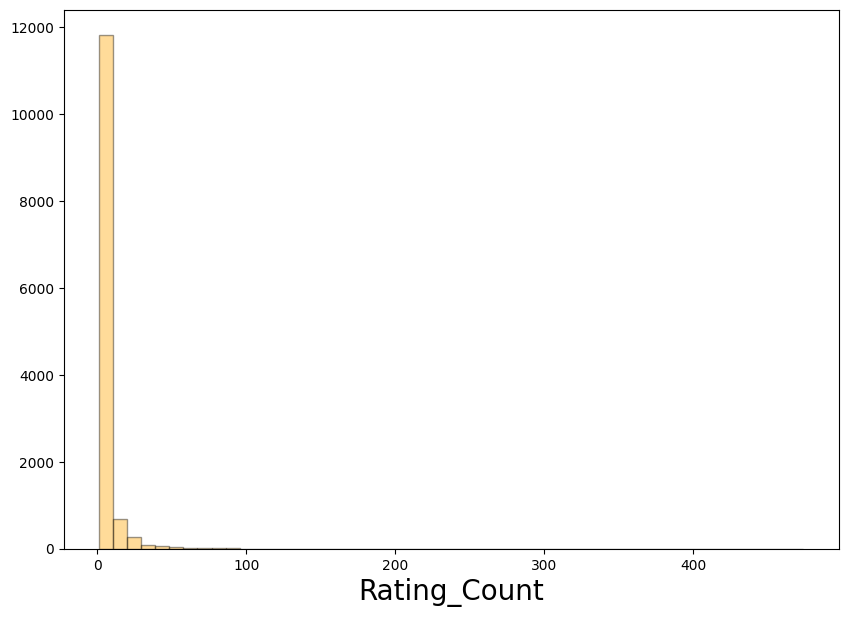

In [45]:
# Top Rating Count Distribution grouped by Users
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_users_Ratings.count()).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['orange'], kde=False)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


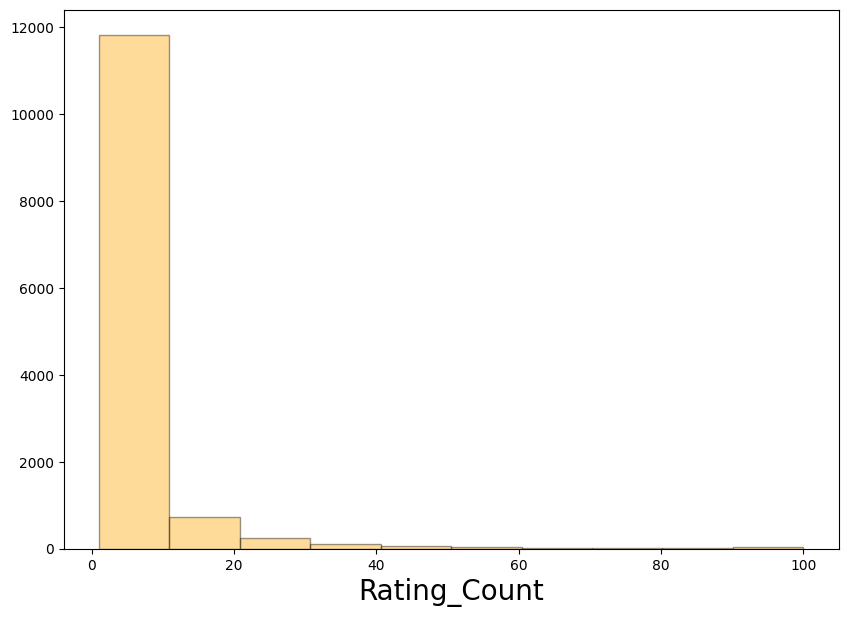

In [46]:
# Top Rating Count Distribution grouped by Users
distplot(1, 1, 10, 7, data=rating_users, features=['Rating_Count'], colors=['orange'], kde=False, bins=10)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


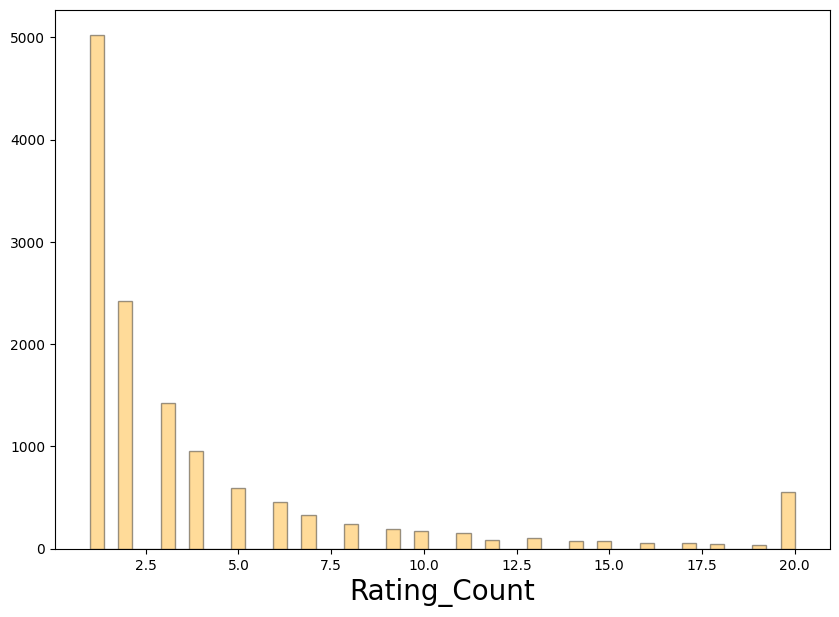

In [47]:
# Top Rating Count Distribution grouped by Users
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_users_Ratings.count().clip(upper=20)).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['orange'], kde=False)

In [48]:
ratings = pd.DataFrame(userRatings.groupby('BGGId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


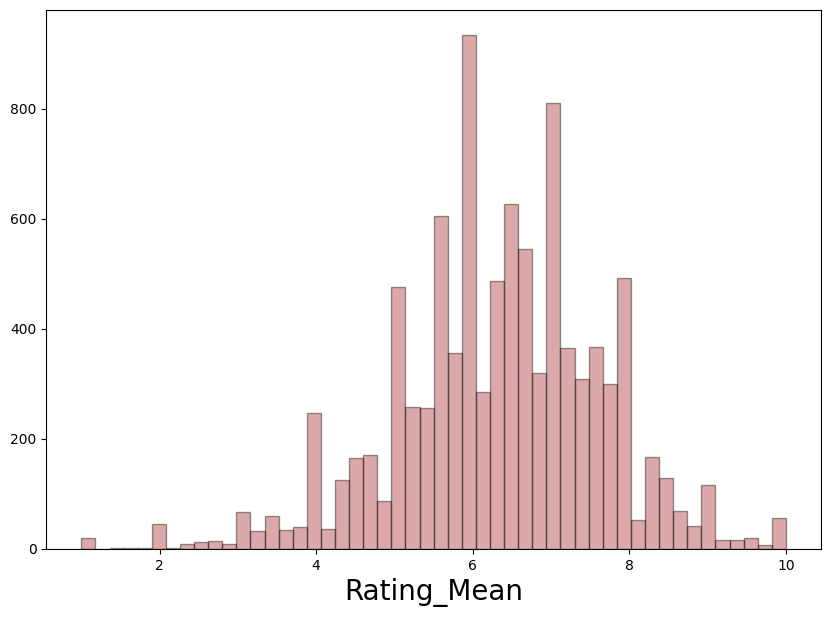

In [49]:
# Mean Rating Distribution grouped by Products
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

In [50]:
ratings['Rating_Count'] = userRatings.groupby('BGGId')['Rating'].count()

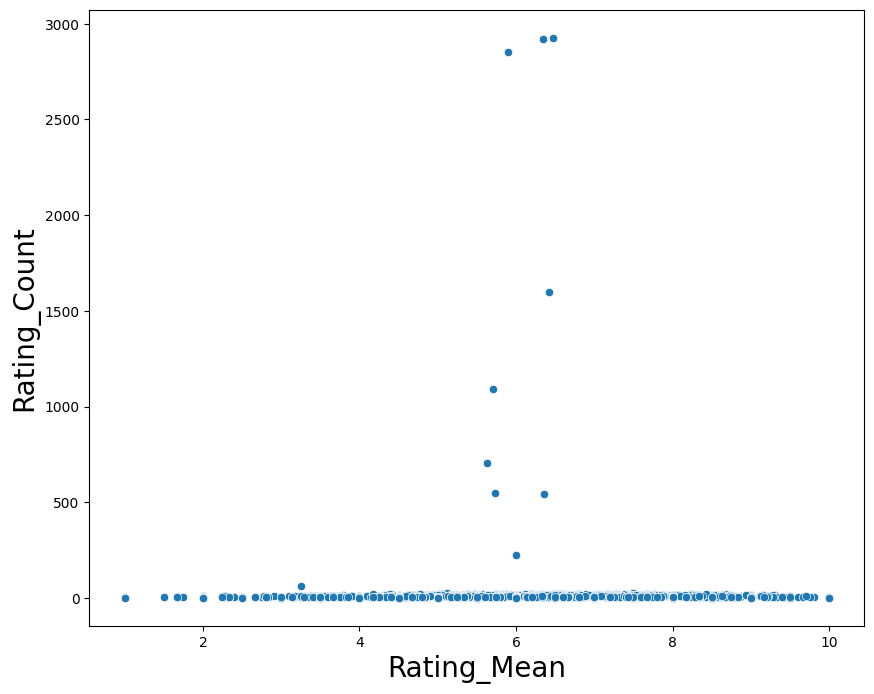

In [51]:
# Mean Rating - Rating Count Distribution grouped by Products
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_7352/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


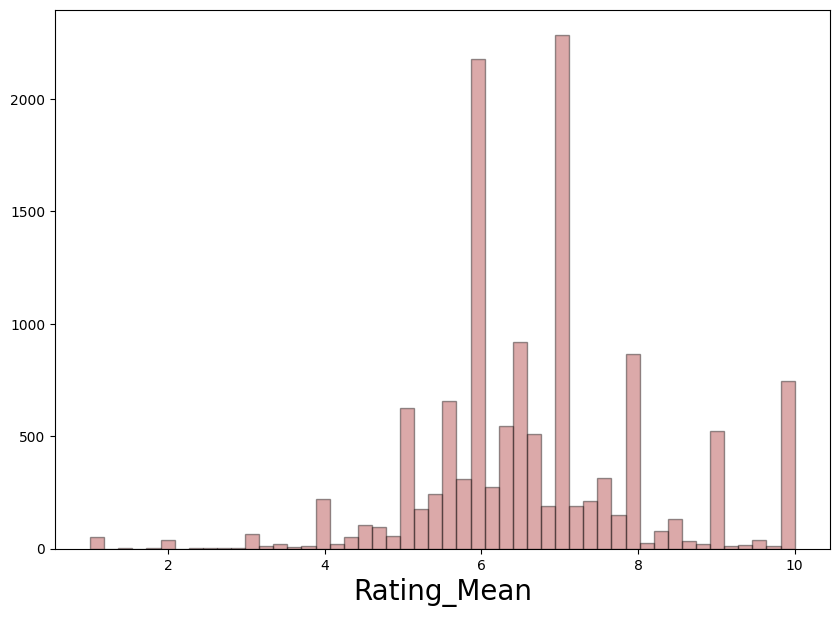

In [52]:
# Mean Rating Distribution grouped by Users
ratings = pd.DataFrame(userRatings.groupby('reducedUsername')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

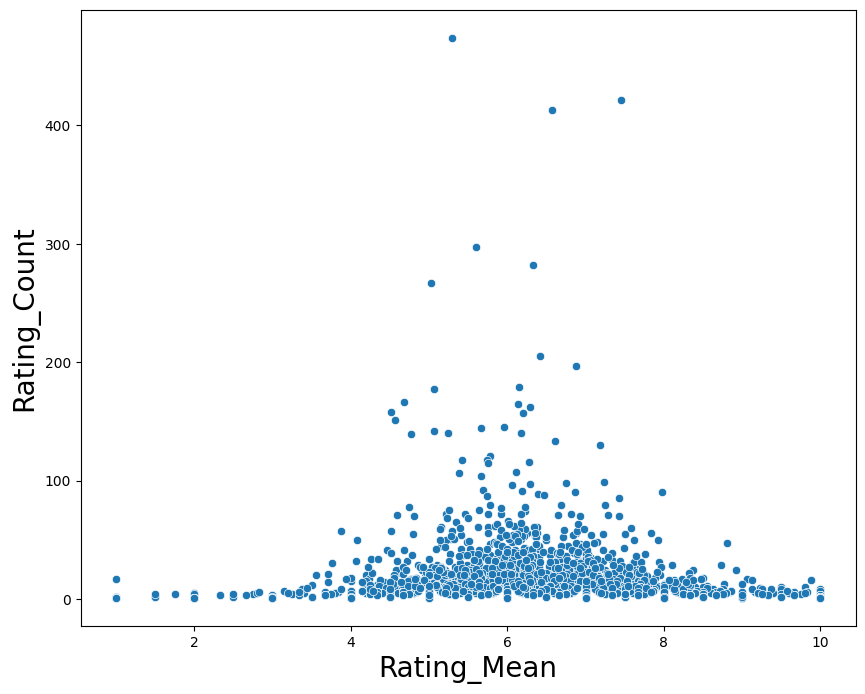

In [53]:
# Mean Rating - Rating Count Distribution grouped by Users
ratings['Rating_Count'] = userRatings.groupby('reducedUsername')['Rating'].count()
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

# BASIC CF AS IMPLEMETED IN [SURPRISE](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)

In [54]:
from surprise import BaselineOnly, Dataset, Reader, dataset
from surprise.model_selection import cross_validate,RandomizedSearchCV,GridSearchCV, KFold
from surprise import KNNWithMeans,KNNWithZScore,SVD,KNNBaseline,KNNBasic, SVDpp
from surprise import accuracy
from surprise.prediction_algorithms.algo_base import AlgoBase
from surprise import PredictionImpossible

from sklearn.pipeline import Pipeline

In [55]:
from sklearn.model_selection import train_test_split
#from surprise.model_selection.split import train_test_split

In [56]:
# Expand the useratings by missing games
# userRatings = pd.concat([games[~games.BGGId.isin(userRatings.BGGId.unique())][["BGGId"]],userRatings],axis=0)

In [57]:
userRatings.BGGId.unique().shape

(9640,)

In [58]:
# items rated only once 
ratingcount = userRatings.groupby("BGGId").size().reset_index()
onlyonce = ratingcount[ratingcount[0]==1].BGGId.unique().tolist()

In [59]:
# Let's keep a subset of the data for final testing
trainset, testset = train_test_split(userRatings[~userRatings.BGGId.isin(onlyonce)], test_size=.3, random_state=10)

In [60]:
trainset = pd.concat([trainset,userRatings[userRatings.BGGId.isin(onlyonce)]],axis=0)

In [61]:
display(trainset.shape)
display(trainset.BGGId.unique().shape)
display(trainset.reducedUsername.unique().shape)

display(testset.shape)
display(testset.BGGId.unique().shape)
display(testset.reducedUsername.unique().shape)

(46041, 5)

(9445,)

(11292,)

(19351, 5)

(6890,)

(7411,)

In [62]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
traindata = Dataset.load_from_df(trainset[["reducedUsername", "BGGId", "Rating"]], reader)

In [63]:
traindata.has_been_split

False

In [64]:
# Since we cannot do pipeline Gridsearch, we will fix the cross valdiation folds for model comparison
cv = KFold(n_splits=3, shuffle=False, random_state = 100)

In [65]:
# model_list = {"KNNBasic_pearson_user":KNNBasic(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNBasic_pearson_item":KNNBasic(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNBasic_cosine_user":KNNBasic(sim_options={'name':'cosine' , 'user_based':True, "min_support":2}),
#              "KNNBasic_cosine_item":KNNBasic(sim_options={'name':'cosine' , 'user_based':False,"min_support":2}),
#              "KNNBasic_MSD_user":KNNBasic(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNBasic_MSD_item":KNNBasic(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNBasic_pearson_baseline_user":KNNBasic(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNBasic_pearson_baseline_item":KNNBasic(sim_options={'name':'pearson_baseline' , 'user_based':False}),
              
#              "KNNWithZScore_pearson_user":KNNWithZScore(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNWithZScore_pearson_item":KNNWithZScore(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNWithZScore_cosine_user":KNNWithZScore(sim_options={'name':'cosine' , 'user_based':True}),
#              "KNNWithZScore_cosine_item":KNNWithZScore(sim_options={'name':'cosine' , 'user_based':False}),
#              "KNNWithZScore_MSD_user":KNNWithZScore(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNWithZScore_MSD_item":KNNWithZScore(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNWithZScore_pearson_baseline_user":KNNWithZScore(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNWithZScore_pearson_baseline_item":KNNWithZScore(sim_options={'name':'pearson_baseline' , 'user_based':False}),

#              "KNNWithMeans_pearson_user":KNNWithMeans(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNWithMeans_pearson_item":KNNWithMeans(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNWithMeans_cosine_user":KNNWithMeans(sim_options={'name':'cosine' , 'user_based':True}),
#              "KNNWithMeans_cosine_item":KNNWithMeans(sim_options={'name':'cosine' , 'user_based':False}),
#              "KNNWithMeans_MSD_user":KNNWithMeans(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNWithMeans_MSD_item":KNNWithMeans(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNWithMeans_pearson_baseline_user":KNNWithMeans(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNWithMeans_pearson_baseline_item":KNNWithMeans(sim_options={'name':'pearson_baseline' , 'user_based':False}),
              
#              "KNNBaseline_pearson_user":KNNBaseline(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNBaseline_pearson_item":KNNBaseline(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNBaseline_cosine_user":KNNBaseline(sim_options={'name':'cosine' , 'user_based':True}),
#              "KNNBaseline_cosine_item":KNNBaseline(sim_options={'name':'cosine' , 'user_based':False}),
#              "KNNBaseline_MSD_user":KNNBaseline(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNBaseline_MSD_item":KNNBaseline(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNBaseline_pearson_baseline_user":KNNBaseline(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNBaseline_pearson_baseline_item":KNNBaseline(sim_options={'name':'pearson_baseline' , 'user_based':False}),
             
#              "SVD":SVD( n_epochs=50)}

In [63]:
# Here the metrics are the average scores over the cross validation folds
# results = pd.DataFrame(index= model_list.keys(), columns=['test_rmse','test_mae','fit_time','test_time'])

In [64]:
# %%time
# for i,v in enumerate(model_list):
#     print(v)
#     dictonary = cross_validate(model_list[v], traindata, cv=cv, verbose=True,)
#     for key in dictonary.keys():
#         results.loc[v,key] = np.mean((dictonary[key]))

In [65]:
# results.sort_values(by=['test_rmse','test_mae'], ascending=True).style.bar(color='#d65f5f')

## Gridsearch for tuning some parameters

In [75]:
model_dict = {"KNNBasic":KNNBasic,
             "KNNWithZScore":KNNWithZScore,
             "KNNWithMeans":KNNWithMeans,
             "SVD": SVD,
             "KNNBaseline":KNNBaseline,
             "SVDpp": SVDpp
             }



In [76]:
similarities = ["pearson",
                "cosine",
                "MSD",
                "pearson_baseline"
                ]

In [77]:
param_dict = {"KNNBasic":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                        },
              "KNNWithZScore":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                        },
                "KNNWithMeans":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                        },
              "KNNBaseline":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                          "bsl_options" : {
                                    "method": ['sgd'],#,
                                    #'reg_i' :[0,5,10],
                                    #'reg_u' : [0,5,10],
                                    'reg': [0.02,0.08,0.5],
                                    "learning_rate": [0.005,0.01,0.05],
                                    'n_epochs': [100]
                                }
                        },
              "SVD":{"n_factors": [10,50,100,150,200], # latent factors
                     "n_epochs": [20,30,40], # sgd iteration
                     "lr_all": [0.002, 0.004,0.006,0.008,0.01], # learning rate of gradient decent
                     "reg_all": [0.02, 0.04,0.06,0.08,0.1], # reg for all parameters
                     "biased": [False, True]},
             
              
              "SVDpp": {"n_factors": [10,50,100], # latent factors
                     "n_epochs": [20,30,40], # sgd iteration
                     "lr_all": [0.002, 0.004,0.006,0.008,0.01], # learning rate of gradient decent
                     "reg_all": [0.02, 0.04,0.06,0.08,0.1], # reg for all parameters
                     #"biased": [False, True]
                       },

             
             
             
             
             
             
             }

In [74]:
def printmd(string, color=None):
    '''Print to track progress'''
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [75]:
gs_results= pd.DataFrame()

#### Traing all defined models dictionary

In [79]:
%%time
for i in model_dict:
    printmd(f"**{i}**", color="blue")
    model = model_dict[i]
    parameters = param_dict[i]
    
    gs = GridSearchCV(model, parameters, measures=["rmse", "mae", "fcp"], cv=cv)
    gs.fit(traindata)
#     joblib.dump(gs, i+'_gridsearch.pkl')
    sub = pd.DataFrame.from_dict(gs.cv_results)
    sub["model"] = i
    gs_results = pd.concat([gs_results,sub])
    #display(gs_results.tail(4))
    printmd("**Done**", color="blue")
    joblib.dump(gs, f'../results/Collaborative filtering/run 3/models/{i}_gridsearch.pkl')
gs_results.to_csv("../results/Collaborative filtering/run 3/Wide CF gridsearch results.csv")

<span style='color:blue'>**KNNBasic**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**KNNWithZScore**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**KNNWithMeans**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**SVD**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**KNNBaseline**</span>

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**SVDpp**</span>

<span style='color:blue'>**Done**</span>

CPU times: user 9h 17min 4s, sys: 7h 47min 52s, total: 17h 4min 56s
Wall time: 17h 6min 16s


In [ ]:
# Next questions to address
# Why does cosine similarity result in zero division for small minimum support like 1?

# Can and should we manually adjust the search space for minimum data based on training data distribution?

## Collective Matrix factorization

In [ ]:
## Define the class for these methodologies

In [66]:
class cmf(AlgoBase):
    def __init__(self,I,k, #k_item,k_main, 
                 lambda_, method, use_cg, user_bias, item_bias, center, add_implicit_features, scale_lam, scale_lam_sideinfo, scale_bias_const, center_I, 
                 niter,maxiter,parallelize, NA_as_zero, NA_as_zero_user, NA_as_zero_item, nonneg, nonneg_C, nonneg_D, include_all_X, random_state, verbose,produce_dicts):

        AlgoBase.__init__(self)
        self.I = I
        self.k = k
        #self.k_user = k_user
        #self.k_item = k_item
        #self.k_main = k_main
        self.lambda_ = lambda_
        #self.l1_lambda = l1_lambda
        self.scale_lam = bool(scale_lam)
        self.scale_lam_sideinfo = bool(scale_lam_sideinfo) or self.scale_lam
        self.scale_bias_const = bool(scale_bias_const)
        #self.alpha = alpha
        #self.w_main = w_main
        #self.w_user = w_user
        #self.w_item = w_item
        #self.w_implicit = w_implicit
        #self.downweight = bool(downweight)
        self.user_bias = bool(user_bias)
        self.item_bias = bool(item_bias)
        self.center = bool(center)
        #self.center_U = bool(center_U)
        self.center_I = bool(center_I)
        self.method = method
        self.add_implicit_features = bool(add_implicit_features)
        #self.apply_log_transf = bool(apply_log_transf)
        self.use_cg = bool(use_cg)
        #self.precondition_cg = bool(precondition_cg)
        #self.max_cg_steps = int(max_cg_steps)
        #self.max_cd_steps = int(max_cd_steps)
        #self.finalize_chol = bool(finalize_chol)
        self.maxiter = maxiter
        self.niter = niter
        self.parallelize = parallelize
        self.NA_as_zero = bool(NA_as_zero)
        self.NA_as_zero_user = bool(NA_as_zero_user)
        self.NA_as_zero_item = bool(NA_as_zero_item)
        self.nonneg = bool(nonneg)
        self.nonneg_C = bool(nonneg_C)
        self.nonneg_D = bool(nonneg_D)
        #self.precompute_for_predictions = bool(precompute_for_predictions)
        self.include_all_X = include_all_X
        #self.use_float = bool(use_float)
        self.verbose = bool(verbose)
        #self.print_every = print_every
        #self.corr_pairs = corr_pairs
        self.random_state = int(random_state)
        self.produce_dicts = bool(produce_dicts)
        #self.handle_interrupt = bool(handle_interrupt)
        #self.nthreads = nthreads

        #self._implicit = bool(implicit)
        #self.dtype_ = ctypes.c_float if use_float else ctypes.c_double

        #self._k_pred = k
        #self._k_main_col = self.k_main

    def fit(self, trainset):

        AlgoBase.fit(self, trainset)

        ### Call the model
        model = CMF(
                k = self.k,
                #self.k_user = k_user
                #k_item = self.k_item,
                #k_main = self.k_main,
                lambda_ = self.lambda_,
                #self.l1_lambda = l1_lambda
                scale_lam = self.scale_lam,
                scale_lam_sideinfo = self.scale_lam_sideinfo,
                scale_bias_const = self.scale_bias_const,
                #self.alpha = alpha
                #self.w_main = w_main
                #self.w_user = w_user
                #self.w_item = w_item
                #self.w_implicit = w_implicit
                #self.downweight = bool(downweight)
                user_bias = self.user_bias,
                item_bias = self.item_bias,
                center = self.center,
                #self.center_U = bool(center_U)
                center_I = self.center_I,
                method = self.method,
                add_implicit_features = self.add_implicit_features,
                #self.apply_log_transf = bool(apply_log_transf)
                use_cg = self.use_cg,
                #self.precondition_cg = bool(precondition_cg)
                #self.max_cg_steps = int(max_cg_steps)
                #self.max_cd_steps = int(max_cd_steps)
                #self.finalize_chol = bool(finalize_chol)
                maxiter = self.maxiter,
                niter = self.niter,
                parallelize = self.parallelize,
                NA_as_zero = self.NA_as_zero,
                NA_as_zero_user = self.NA_as_zero_user,
                NA_as_zero_item = self.NA_as_zero_item,
                nonneg = self.nonneg,
                nonneg_C = self.nonneg_C,
                nonneg_D = self.nonneg_D,
                #self.precompute_for_predictions = bool(precompute_for_predictions)
                include_all_X = self.include_all_X,
                #self.use_float = bool(use_float)
                verbose = self.verbose,
                #self.print_every = print_every
                #self.corr_pairs = corr_pairs
                random_state = self.random_state,
                produce_dicts = self.produce_dicts,
                n_jobs = -1
        
        )
        df = pd.DataFrame([(trainset.to_raw_uid(u), 
                            trainset.to_raw_iid(i), 
                            r) for (u, i, r) in trainset.all_ratings()],
                          columns=["reducedUsername","BGGId","Rating"])
#         df = trainset.df
        
        # Manual reindexing
#         user_map = dict(zip(df.reducedUsername.unique().tolist(),pd.Series(df.reducedUsername.unique().tolist()).index.tolist()))
#         games_map = dict(zip(df.BGGId.unique().tolist(),pd.Series(df.BGGId.unique().tolist()).index.tolist()))
        
#         X = df.copy()
#         I = self.I.copy()
        
#         X["UserId"] = X.reducedUsername.map(user_map)
#         X["ItemId"] = X.BGGId.map(games_map)
        
#         unrated_items = I[~I.BGGId.isin(games_map.keys())]
#         games_map_unrated  = dict(zip(unrated_items.BGGId.unique().tolist(),list(range((X["ItemId"].max() + 1),I["BGGId"].shape[0]))))
        
#         games_map_unrated.update(games_map)

#         I["ItemId"] = I.BGGId.map(games_map_unrated

        
#         model.fit(X=X[["UserId","ItemId","Rating"]].copy(),
#                   I=I.drop(columns))
        # Assuming automatic indexing
    
        X = df.rename(columns={"BGGId":"ItemId","reducedUsername":"UserId"})[["UserId","ItemId","Rating"]]
        
        if self.I == "mechanics":
            I = mechanics.rename(columns={"BGGId":"ItemId"})
        if self.I == "themes":
            I = themes.rename(columns={"BGGId":"ItemId"})
        if self.I == "subcat":
            I = subcat.rename(columns={"BGGId":"ItemId"})
        if self.I == "cat":
            I = cat.rename(columns={"BGGId":"ItemId"})
        if self.I == "game_info":
            I = game_info.rename(columns={"BGGId":"ItemId"})
        if self.I == "rank":
            I = rank.rename(columns={"BGGId":"ItemId"})
        if self.I == "all":
            I = all_sideinfo.rename(columns={"BGGId":"ItemId"})
            

#         I = self.I.rename(columns={"BGGId":"ItemId"})
        
        
        model.fit(X=X,
                  I=I)
        self.cmf = model

        

        return self

    def estimate(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")

        cmf_model = self.cmf
        prediction = cmf_model.predict(u,i)
        return prediction

In [67]:
## Let's see how the games are represented in the additional informations

In [70]:
import plotly.express as px
from sklearn.decomposition import PCA
def PCA_visuals(df,id_col,features,rated):
    if id_col in features:
        features.remove(id_col)
    pca = PCA()
    components = pca.fit_transform(df[features])
    display(pca.explained_variance_ratio_)
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    fig = px.scatter_matrix(
        components,
        labels=labels,
        dimensions=range(4),
        color=rated
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()

In [71]:
# pca_Dataset = game_info
# PCA_visuals(df=pca_Dataset,id_col="BGGId",features=pca_Dataset.columns.tolist(),rated=pca_Dataset.BGGId.isin(userRatings.BGGId))

## Grid search for CMF

In [68]:
model_dict_cmf_als = {"cmf_bias_mechanics":{
                        "I":["mechanics"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["als"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [True],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_mechanics":{
                        "I":["mechanics"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k":[30,50,70], #[10,50,100,150,200] 
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06],[0,0],[0.02,0.06])],#[0.02, 0.04,0.06,0.08,0.1]
                        "method": ["als"], 
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_themes":{
                        "I":["themes"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["als"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [True],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_themes":{
                        "I":["themes"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k":[30,50,70], #[10,50,100,150,200] 
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06],[0,0],[0.02,0.06])],#[0.02, 0.04,0.06,0.08,0.1]
                        "method": ["als"], 
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_subcat":{
                        "I":["subcat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["als"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [True],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_subcat":{
                        "I":["subcat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k":[30,50,70], #[10,50,100,150,200] 
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06],[0,0],[0.02,0.06])],#[0.02, 0.04,0.06,0.08,0.1]
                        "method": ["als"], 
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_cat":{
                        "I":["cat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["als"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [True],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_cat":{
                        "I":["cat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k":[30,50,70], #[10,50,100,150,200] 
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06],[0,0],[0.02,0.06])],#[0.02, 0.04,0.06,0.08,0.1]
                        "method": ["als"], 
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_game_info":{
                        "I":["game_info"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["als"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [True],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_game_info":{
                        "I":["game_info"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k":[30,50,70], #[10,50,100,150,200] 
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06],[0,0],[0.02,0.06])],#[0.02, 0.04,0.06,0.08,0.1]
                        "method": ["als"], 
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
            "cmf_bias_rank":{
                        "I":["rank"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["als"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [True],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_rank":{
                        "I":["rank"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k":[30,50,70], #[10,50,100,150,200] 
                        "lambda_"   :[0.02,0.06,0.08],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06],[0,0],[0.02,0.06])],#[0.02, 0.04,0.06,0.08,0.1]
                        "method": ["als"], 
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [True, False],
                        "scale_lam":[True],
                        "scale_lam_sideinfo": [True],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[200],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    }
             }

In [82]:
model_dict_cmf_sgd = {"cmf_bias_mechanics":{
                        "I":["mechanics"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_mechanics":{
                        "I":["mechanics"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_themes":{
                        "I":["themes"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_themes":{
                        "I":["themes"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_subcat":{
                        "I":["subcat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_subcat":{
                        "I":["subcat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_cat":{
                        "I":["cat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_cat":{
                        "I":["cat"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                "cmf_bias_game_info":{
                        "I":["game_info"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_game_info":{
                        "I":["game_info"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
            "cmf_bias_rank":{
                        "I":["rank"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_rank":{
                        "I":["rank"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_bias_all":{
                        "I":["all"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [True],
                        "item_bias": [True],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    },
                  "cmf_nonbias_all":{
                        "I":["all"],
  # [games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]]],
                        "k": [30,50,70], #[10,50,100,150,200]
                        "lambda_":[20,25,30,35,40,45],#[list(element) for element in itertools.product([0.02,0.06], [0.02,0.06],[0.02,0.06],[0.02,0.06,0.1],[0,0],[0.02,0.06])],
                        "method": ["lbfgs"],
                        "use_cg": [False],
                        "user_bias": [False],
                        "item_bias": [False],
                        "center": [True, False],
                        "add_implicit_features": [False],
                        "scale_lam":[False],
                        "scale_lam_sideinfo": [False],
                        "scale_bias_const": [False],
                        #"k_item" : [30,50,70,100],
                        #"k_main" : [30,50,70,100],
                        "center_I": [True, False],
                        "niter": [50],
                        "maxiter":[0],
                        "parallelize":['separate'],
                        "NA_as_zero": [False],
                        "NA_as_zero_user": [False],
                        "NA_as_zero_item": [False],
                        "nonneg": [False],
                        "nonneg_C": [False],
                        "nonneg_D": [False],
                        "include_all_X": [True],
                        "random_state": [100],
                        "verbose": [False],
                        "produce_dicts":[True],
                    }
             }

In [83]:
gs_results= pd.DataFrame()


In [84]:
def runner(model,model_dict,prefix,run=3):
    for i in model_dict:
        printmd(f"**{i}**", color="blue")
        #for lambdas in [list(element) for element in itertools.product([0.02,0.06,0.1], [0.02,0.06,0.1],[0.02,0.06,0.1],[0.02,0.06,0.1],[0.02,0.06,0.1],[0.02,0.06,0.1])]:
        parameters = model_dict[i]
        #parameters["lambda_"] = lambdas
        gs = GridSearchCV(model, parameters, measures=["rmse", "mae", "fcp"], cv=cv)
        gs.fit(traindata)
        joblib.dump(gs, f'../results/Collaborative filtering/run {run}/models/cmf/{i}'+ prefix  +'_gridsearch.pkl')
        sub = pd.DataFrame.from_dict(gs.cv_results)
        sub["model"] = i
        gs_results = pd.concat([gs_results,sub])
            #display(gs_results.tail(4))
        printmd("**Done**", color="blue")

    gs_results.to_csv(f"../results/Collaborative filtering/run {run}/CMF"+prefix+" gridsearch results.csv")

In [ ]:
%%time
runner(
        model = cmf,
        model_dict = model_dict_cmf_sgd,
        prefix = "sgd",
        run =3
)

<span style='color:blue'>**cmf_bias_mechanics**</span>

In [74]:
%%time
for i in model_dict_cmf:
    printmd(f"**{i}**", color="blue")
    model = cmf
    #for lambdas in [list(element) for element in itertools.product([0.02,0.06,0.1], [0.02,0.06,0.1],[0.02,0.06,0.1],[0.02,0.06,0.1],[0.02,0.06,0.1],[0.02,0.06,0.1])]:
    parameters = model_dict_cmf[i]
    #parameters["lambda_"] = lambdas
    gs = GridSearchCV(model, parameters, measures=["rmse", "mae", "fcp"], cv=cv)
    gs.fit(traindata)
    joblib.dump(gs, f'../results/Collaborative filtering/run 3/models/cmf/{i}_gridsearch.pkl')
    sub = pd.DataFrame.from_dict(gs.cv_results)
    sub["model"] = i
    gs_results = pd.concat([gs_results,sub])
        #display(gs_results.tail(4))
    printmd("**Done**", color="blue")
    
gs_results.to_csv("../results/Collaborative filtering/run 3/CMF gridsearch results.csv")


<span style='color:blue'>**cmf_bias_mechanics**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_nonbias_mechanics**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_bias_themes**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_nonbias_themes**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_bias_subcat**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_nonbias_subcat**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_bias_cat**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_nonbias_cat**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_bias_game_info**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_nonbias_game_info**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_bias_rank**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**cmf_nonbias_rank**</span>

<span style='color:blue'>**Done**</span>

CPU times: user 1d 22h 52min 34s, sys: 7h 4min 36s, total: 2d 5h 57min 11s
Wall time: 7h 24min 38s


In [71]:
# gs_results.mean_test_rmse.min()

1.6935561179704612

In [74]:
# gs_results.mean_test_fcp.max()

0.39967260404324106

In [ ]:
# model = cmf
# gs = GridSearchCV(model, model_dict_cmf["cmf"], measures=["rmse", "mae", "fcp"], cv=cv)
# gs.fit(traindata)

In [ ]:
# pd.DataFrame.from_dict(gs.cv_results)

In [ ]:
# gs.cv_results

In [ ]:
# pd.DataFrame.from_dict(gs.cv_results).to_csv("../results/Collaborative filtering/run 2/CMF gridsearch results.csv")

In [ ]:
# joblib.dump(gs,"../results/Collaborative filtering/run 2/CMF_gridsearch.pkl")

In [ ]:
# NEXT STEPS

# #Add ItemId to games, themes (all that use BGGId)
# Re index both inside the fit function
# inside fit function save the userID mapping and use it predict a rating (usig item id from self.I)


In [ ]:

####################################################################################################################


In [ ]:
# ### CMF
# !pip install cmfrec

In [81]:
# help(CMF)

Help on class CMF in module cmfrec:

class CMF(_CMF)
 |  CMF(k=40, lambda_=10.0, method='als', use_cg=True, user_bias=True, item_bias=True, center=True, add_implicit_features=False, scale_lam=False, scale_lam_sideinfo=False, scale_bias_const=False, k_user=0, k_item=0, k_main=0, w_main=1.0, w_user=1.0, w_item=1.0, w_implicit=0.5, l1_lambda=0.0, center_U=True, center_I=True, maxiter=800, niter=10, parallelize='separate', corr_pairs=4, max_cg_steps=3, precondition_cg=False, finalize_chol=True, NA_as_zero=False, NA_as_zero_user=False, NA_as_zero_item=False, nonneg=False, nonneg_C=False, nonneg_D=False, max_cd_steps=100, precompute_for_predictions=True, include_all_X=True, use_float=True, random_state=1, verbose=True, print_every=10, handle_interrupt=True, produce_dicts=False, nthreads=-1, n_jobs=None)
 |  
 |  Collective or multi-view matrix factorization
 |  
 |  Tries to approximate the 'X' interactions matrix  by a formula as follows:
 |      
 |      :math:`\mathbf{X} \sim \mathbf{A}  

In [ ]:
# for i in model_dict["cmf"].keys():
#     print

In [ ]:
# ### Fit the model
# model = CMF(method="als")
# X = userRatings.rename(columns={"BGGId":"ItemId","reducedUsername":"UserId"})[["UserId","ItemId","Rating"]]
# X["UserId"].fillna(X["UserId"].mode().values[0],inplace=True)

# I = games[["BGGId"]+[i for i in games.columns if "Cat:" in i ]].rename(columns={"BGGId":"ItemId"})
# model.fit(X=X,
#           I=I)



In [ ]:
# model.item_mapping_

In [ ]:
# model.user_mapping_

In [ ]:
# model.predict('A Friend of Grouchy',6)

In [ ]:
# model.predict(0,0)

In [ ]:
# model.predict("0",6)

In [ ]:
# userRatings.head()

In [ ]:
# gs = GridSearchCV(CMF, model_dict["cmf"], measures=["rmse", "mae", "fcp"], cv=cv)


In [ ]:
# gs.fit(traindata)

#### Lets build a pipeline for hyperparameter tuning and model selection all at once

In [ ]:
# from enum import Enum
# class Model(Enum):
#     KNNWithZScore='z standrdized CF'
#     KNNWithMeans='baseline centered CF'
#     all= 'best model'



# model_list = [e for e in Model if e != Model.all]
# model_instances = []
# params = []

# num_folds = 5  # Hard coded
# scoring = ['rmse', 'mae']

# #clf1 = KNNWithZScore(verbose=True)
# #param1 = {}
# #param1['k'] = [50]
# #param1['sim_options'] =  {
# #                                        'name': ['pearson', 'cosine'],
# #                                        'min_support': [1, 5],
# #                                        'user_based': [False, True],
# #                                    }
# #param1['regressor'] = [clf1]
# #model_instances.append(clf1)
# #params.append(param1)

# gs = GridSearchCV(clf1, param1, cv=num_folds, measures=scoring, refit=True,joblib_verbose=2)


# gs.fit(traindata)

# if Model.KNNWithZScore in model_list:
#         clf1 = KNNWithZScore#(verbose=True)
#         param1 = {}
#         param1['regressor__k'] = [50]
#         param1['regressor__sim_options'] =  {
#                                                 'name': ['pearson', 'cosine'],
#                                                 'min_support': [1, 5],
#                                                 'user_based': [False, True],
#                                             },
#         param1['regressor'] = [clf1]
#         model_instances.append(clf1)
#         params.append(param1)


        
# pipeline = Pipeline([('regressor', model_instances[0])])


# gs = GridSearchCV(pipeline, params, cv=num_folds, measures=scoring, refit=True,joblib_verbose=2)

# gs.fit(traindata)


In [ ]:
# sim_options = {
#     "name": ["msd", "cosine", "pearson", "pearson_baseline"],
#     #"min_support": [3, 4, 5],
#     "user_based": [False],
# }

In [ ]:
# knn_model = KNNWithMeans(k=10,sim_options={'name':'pearson' , 'user_based':True})
# knn_model.fit(traindata)

In [ ]:
# accuracy.rmse(test_pred_knn)

In [ ]:
# #Evaluation on testset

# test_pred_knn=knn_model.test(testset)

# # compute RMSE
# accuracy.rmse(test_pred_knn)

In [ ]:
# test_pred_df = pd.DataFrame(test_pred_knn)

In [ ]:
# test_pred_df.sort_values(by=["uid","iid","r_ui"], ascending=False)

In [ ]:
# # Use the famous SVD algorithm.
# algo = SVD()

# # Run 5-fold cross-validation and print results.
# cross_validate(algo, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# sim_options = {
#     "name": ["msd", "cosine", "pearson", "pearson_baseline"],
#     "min_support": [3, 4, 5],
#     "user_based": [True],
# }

In [ ]:
# cross_validate(KNNWithZScore(sim_options=sim_options), traindata, cv=2)

In [ ]:
# cv_result = cross_validate(KNNWithZScore(sim_options=sim_options), trainset, cv=5)

In [ ]:
# from collections import defaultdict

# def get_top_n(predictions, n=10):
#     # First map the predictions to each user.
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))

#     # Then sort the predictions for each user and retrieve the k highest ones.
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]

#     return top_n


In [ ]:
# class collab_filtering_based_recommender_model():
#     def __init__(self, model, trainset, testset, data):
#         self.model = model
#         self.trainset = trainset
#         self.testset = testset
#         self.data = data
#         self.pred_test = None
#         self.recommendations = None
#         self.top_n = None
#         self.recommenddf = None

#     def fit_and_predict(self):        
#         printmd('**Fitting the train data...**', color='brown')
#         self.model.fit(self.trainset)       

#         printmd('**Predicting the test data...**', color='brown')
#         self.pred_test = self.model.test(self.testset)        
#         rmse = round(accuracy.rmse(self.pred_test), 3)
#         printmd('**RMSE for the predicted result is ' + str(rmse) + '**', color='brown')   
        
#         self.top_n = get_top_n(self.pred_test)
#         self.recommenddf = pd.DataFrame(columns=['userId', 'productId', 'Rating'])
#         for item in self.top_n:
#             subdf = pd.DataFrame(self.top_n[item], columns=['productId', 'Rating'])
#             subdf['userId'] = item
#             cols = subdf.columns.tolist()
#             cols = cols[-1:] + cols[:-1]
#             subdf = subdf[cols]        
#             self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
#         return rmse
        
#     def cross_validate(self):
#         printmd('**Cross Validating the data...**', color='brown')
#         cv_result = cross_validate(self.model, self.data, n_jobs=-1)
#         cv_result = round(cv_result['test_rmse'].mean(),3)
#         printmd('**Mean CV RMSE is ' + str(cv_result)  + '**', color='brown')
#         return cv_result

#     def recommend(self, user_id, n=5):
#         printmd('**Recommending top ' + str(n)+ ' products for userid : ' + user_id + ' ...**', color='brown')
        
#         #df = pd.DataFrame(self.top_n[user_id], columns=['productId', 'Rating'])
#         #df['UserId'] = user_id
#         #cols = df.columns.tolist()
#         #cols = cols[-1:] + cols[:-1]
#         #df = df[cols].head(n)
#         df = self.recommenddf[self.recommenddf['userId'] == user_id].head(n)
#         display(df)
#         return df

In [ ]:
# from surprise.model_selection import RandomizedSearchCV

# def find_best_model(model, parameters,data):
#     clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
#     clf.fit(data)             
#     print(clf.best_score)
#     print(clf.best_params)
#     print(clf.best_estimator)
#     return clf

In [ ]:
# sim_options = {
#     "name": ["msd", "cosine", "pearson", "pearson_baseline"],
#     "min_support": [3, 4, 5],
#     "user_based": [True],
# }
# params = { 'k': range(30,50,1), 'sim_options': sim_options}


In [ ]:
# clf = find_best_model(KNNWithZScore, params, trainset)